In [1]:
# AI2 THOR
!pkill thor_*
import ai2thor
from ai2thor.controller import Controller,BFSController
from ai2thor.platform import CloudRendering
from ithor_tools.vis_tool import *
from ithor_tools.transform import cornerpoint_projection,depth2world
from ithor_tools.landmark_utils import vis_panorama
from eval_ithor.objects import choose_query_objects


from co_occurance.comet_co import co_occurance_score
import random
import math
# from IPython.display import display
# from moviepy.editor import ImageSequenceClip,VideoFileClip


# Planning Module
from RRT import gridmaprrt as rrt
from RRT import gridmaprrt_pathsmoothing as smoothing

from FBE.memory import fbe_map
from FBE.schedular import traj_schedular

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# Detector module
from osod.data.phase_1 import load_voc_instances,VOC_CLASS_NAMES
import torch
import cv2
import copy
import matplotlib.pyplot as plt
from osod.structures.box import Boxes
from osod.engine.predictor import DefaultPredictor

from osod.config.config import get_cfg
from osod.model.rcnn import GeneralizedRCNN
from detector.postprocess import postprocess,plot_openset,plot_candidate

## Matching Module
from detector.query_matching import matcher

In [4]:
gridSize=0.05
scene_name = "FloorPlan_Val1_1"
controller = Controller(
    platform = CloudRendering,
    agentMode="locobot",
    visibilityDistance=5.0,
    scene = scene_name,
    gridSize=gridSize,
    movementGaussianSigma=0,
    rotateStepDegrees=90,
    rotateGaussianSigma=0,
    renderClassImage = True,
    renderDepthImage=False,
    renderInstanceSegmentation=False,
    width=300,
    height=300,
    fieldOfView=60
)

controller.reset(
    # makes the images a bit higher quality
    width=800,
    height=800,

    # Renders several new image modalities
    renderDepthImage=True,
    renderClassImage = True,
    renderSemanticSegmentation=False,
    renderNormalsImage=False
)
scene_bounds = controller.last_event.metadata['sceneBounds']['center']
controller.step(
    action="AddThirdPartyCamera",
    position=dict(x=scene_bounds['x'], y=5.0, z=scene_bounds['z']),
    rotation=dict(x=90, y=0, z=0),
    orthographic=True,
    orthographicSize= 5.0, fieldOfView=100,
    skyboxColor="white"
)
controller.step(dict(action='GetReachablePositions'))
rstate = controller.last_event.metadata['actionReturn']

controller.step(
    action="Teleport",
    position = rstate[100]
)

pos = controller.last_event.metadata['agent']['position']
pos = [pos['x'],pos['z']]
objects = controller.last_event.metadata['objects']

INFO - 2022-07-04 15:01:32,883 - controller - Initialize return: {'cameraNearPlane': 0.10000000149011612, 'cameraFarPlane': 20.0}


In [7]:
scene_bounds = controller.last_event.metadata['sceneBounds']['cornerPoints']
scene_bounds = cornerpoint_projection(scene_bounds)


In [8]:
query_object = objects[2]
in_landmark_names = ['diningtable','sofa','tvmonitor']
out_landmark_names = ['desk','drawer','side table','coffee table','bed','arm chair']
landmark_names = in_landmark_names+out_landmark_names

scene_memory = fbe_map(scene_bounds,rstate,landmark_names=landmark_names, stepsize=0.1)

0.6868000030517578 10.52444076538086 -5.351839542388916 0.5981607437133789


In [9]:
detection_labels = []
for l in in_landmark_names:
    detection_labels.append(VOC_CLASS_NAMES.index(l))
print(detection_labels)

[10, 17, 19]


In [10]:
'''
config file
'''

print(torch.cuda.device_count())
torch.cuda.set_device(0)
print(torch.cuda.current_device())
cfg = get_cfg()
cfg.merge_from_file('../Open-Set-Object-Detection/config_files/voc.yaml')
cfg.MODEL.SAVE_IDX=19 #22
cfg.MODEL.RPN.USE_MDN=False
cfg.log = False 
cfg.MODEL.ROI_HEADS.USE_MLN = True
cfg.MODEL.ROI_HEADS.AUTO_LABEL = False
cfg.MODEL.ROI_HEADS.AF = 'baseline'
cfg.MODEL.RPN.AUTO_LABEL = False
cfg.MODEL.ROI_BOX_HEAD.USE_FD = False
cfg.MODEL.RPN.AUTO_LABEL_TYPE = 'sum'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 21
cfg.INPUT.RANDOM_FLIP = "none"
cfg.MODEL.ROI_HEADS.UNCT = True
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.2
cfg.PATH = '../Open-Set-Object-Detection'
cfg.phase = 'voc'
# cfg.merge_from_list(args.opts)
RPN_NAME = 'mdn' if cfg.MODEL.RPN.USE_MDN else 'base'
ROI_NAME = 'mln' if cfg.MODEL.ROI_HEADS.USE_MLN else 'base'
MODEL_NAME = RPN_NAME + ROI_NAME
# cfg.merge_from_list(args.opts)
cfg.freeze()
# wandb.init(config=cfg,tags= 'temp',name = 'temp',project='temp')

device = 'cuda:0'
model = GeneralizedRCNN(cfg,device = device).to(device)
state_dict = torch.load('../Open-Set-Object-Detection/ckpt/{}/{}_{}_15000.pt'.format(cfg.MODEL.ROI_HEADS.AF,cfg.MODEL.SAVE_IDX,MODEL_NAME),map_location=device)
pretrained_dict = {k: v for k, v in state_dict.items() if k in model.state_dict()}
model.load_state_dict(pretrained_dict)

predictor = DefaultPredictor(cfg,model)

2
0


WARNING - 2022-07-04 15:02:14,437 - warnings - /home/jeongeun/test_env/Open-Set-Object-Detection/model/rpn/rpn.py:45: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(layers.weight,std=0.01)

WARNING - 2022-07-04 15:02:14,476 - warnings - /home/jeongeun/test_env/Open-Set-Object-Detection/model/rpn/rpn.py:46: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(layers.bias,0)



In [11]:
VOC_CLASS_NAMES_NEW = (*VOC_CLASS_NAMES, 'unknown')

In [12]:
clip_matcher = matcher(out_landmark_names,device='cuda:0')
clip_matcher.tokenize(query_object['objectType'])


In [20]:
controller.step(
    action="Teleport",
    position = rstate[105],
    rotation = dict(x=0,y=180,z=0)
)
d2w = depth2world()

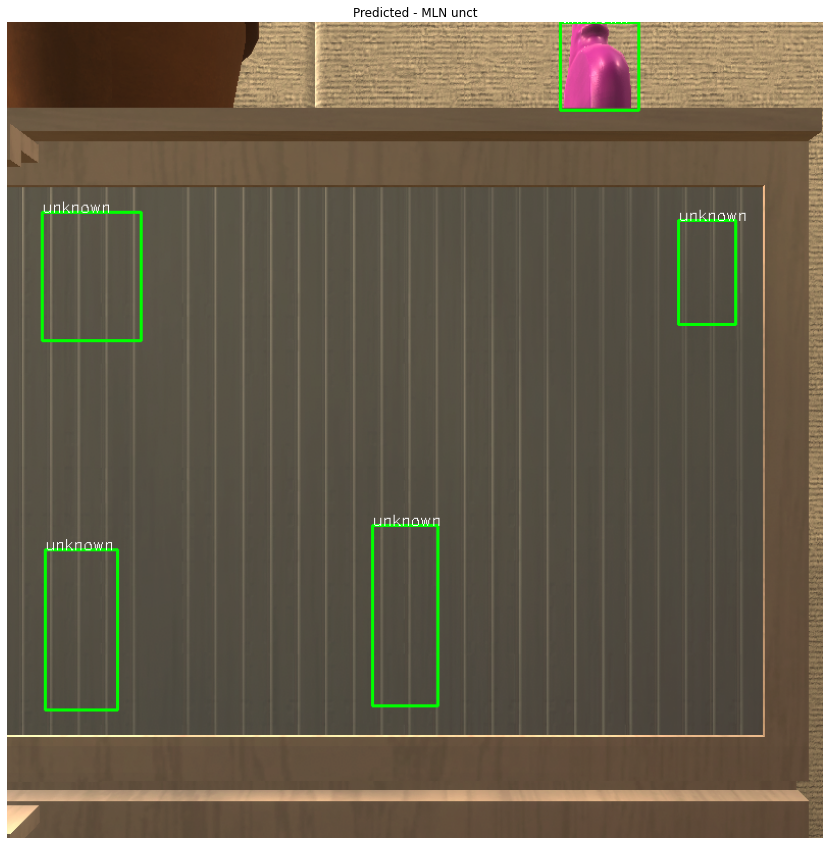

In [21]:
img = controller.last_event.cv2img
pred = predictor(img)
pred_boxes, pred_classes,unk_only,_ = postprocess(pred)

# pred_boxes = pred_boxes[unk_only]
plot_openset(img,pred_boxes,pred_classes,VOC_CLASS_NAMES_NEW)